# Battle of the Neighbourhoods - Relocation
Project by Thomas Buchan
## Introduction
People have to relocate to new cities for a variety of work and family reasons and this process can be a stressful and challenging time. Having additional information about areas of a new city/country that your relocating to can aid in the process making it smoother, less stressful and leading to an overall better outcome. This project aims to look at location and Foursquare API data to see how this can be used to aid the relocation process.


## Main Notebook

In this notebook I taker the previously web scraped city location information and now use foursquare to obtain the information of facilities around the different boroughs. This will then be compared to information taken from current location of Larnaca, Cyprus.


No

# Part 1 - LONDON
## Step 1 - Import Location Data
The location data was web scraped from wikipedia and the full notebook for this process is in this github repository as;

BON_London_Data1

BON_London_Data2

Two different web pages were used between version 1 and version 2 with the Boroughs collected in 1 and the full post code break down collected in the other. For the purposes of this project the 32 boroughs were used however more specific information on areas within each borough could be determined through using the post code neighborhoods.

In [1]:
# import libraries
import numpy as np
import time
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import lxml 
import xlrd
import pandas as pd
from bs4 import BeautifulSoup 
import json 
import requests 
from pandas.io.json import json_normalize 
from geopy.geocoders import Nominatim 

import folium

In [2]:
# take the csv from london in, steps in other notebook
df_lon = pd.read_csv('Data_London.csv')

In [3]:
df_lon.head()

,BoroughName,Population,Latitude,Longitude
0,Barking and Dagenham,194352,51.5607,0.1557
1,Barnet,369088,51.6252,-0.1517
2,Bexley,236687,51.4549,0.1505
3,Brent,317264,51.5588,-0.2817
4,Bromley,317899,51.4039,0.0198


In [4]:
address = 'London'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_lon = location.latitude
longitude_lon = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude_lon, longitude_lon))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [5]:
#London, the UK Latitude and longitude coordinates are: 51.509865, -0.118092 from web - use this for centering the folium map
Lat = latitude_lon
Long = longitude_lon
London_map = folium.Map(location=[Lat, Long], zoom_start=10)

for lat, lng, borough, neighbourhood in zip(df_lon['Latitude'], df_lon['Longitude'], df_lon['BoroughName'], df_lon['Population']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='blue', fill=True).add_to(London_map)

London_map

In [6]:
# take the csv from New York in
df_ny = pd.read_csv('Data_NewYork.csv')

In [7]:
df_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_ny = location.latitude
longitude_ny = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude_ny, longitude_ny))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [9]:
#London, the UK Latitude and longitude coordinates are: 51.509865, -0.118092 from web - use this for centering the folium map
Lat = latitude_ny
Long = longitude_ny
ny_map = folium.Map(location=[Lat, Long], zoom_start=10)

for lat, lng, borough, neighbourhood in zip(df_ny['Latitude'], df_ny['Longitude'], df_ny['Borough'], df_ny['Neighborhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='blue', fill=True).add_to(ny_map)

ny_map

## Step 2 - Venue Data Mining
### Get Foursquare credentials and obtain information

Use the Foursquare API with my user credentials to send a request for venue information from the Foursquare website. The top 200 venues for each of the different neighbourhoods/boroughs are obtained. A limit of 200 venues and radius limit from the central point of each neighborhood/borough was put in place to allow easier processing of this data and due to limited number of Foursquare requests. 

In [10]:
#Define foursquare credentials - Taken from the lab on manhatten and applied to toronto

CLIENT_ID = 'JYF4SUTSIUBZHRWW2QJ2D0YO4VYW1W0FIOI512Y11T34L05I' # your Foursquare ID
CLIENT_SECRET = 'NFQO2ABF0M0PW0D514EVCSERJ3U0GZLVDY02YST44JSSPYY1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JYF4SUTSIUBZHRWW2QJ2D0YO4VYW1W0FIOI512Y11T34L05I
CLIENT_SECRET:NFQO2ABF0M0PW0D514EVCSERJ3U0GZLVDY02YST44JSSPYY1


### Defining the Function to obtain  Venues in each neighborhood

This is the function and can then be used for the different cities for any given location file, a radius of 700m was selected and 200 venues. 

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
# chanhge this for london
london_venues = getNearbyVenues(names=df_lon['BoroughName'], #its borough name london and neighbourhood new york
                                   latitudes=df_lon['Latitude'],
                                   longitudes=df_lon['Longitude']
                                  )

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [14]:
print(london_venues.shape)
london_venues.head()

(1953, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.5607,0.1557,Central Park,51.559560,0.161981,Park
1,Barking and Dagenham,51.5607,0.1557,Lara Grill,51.562445,0.147178,Turkish Restaurant
2,Barking and Dagenham,51.5607,0.1557,Iceland,51.560578,0.147685,Grocery Store
3,Barking and Dagenham,51.5607,0.1557,Shell,51.560415,0.148364,Gas Station
4,Barking and Dagenham,51.5607,0.1557,Morrisons,51.559774,0.148752,Supermarket


In [15]:
london_venues.groupby('Neighborhood').count()
#note many maxed out at 100 venues from the search

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Barking and Dagenham,12,12,12,12,12,12
Barnet,6,6,6,6,6,6
Bexley,37,37,37,37,37,37
Brent,84,84,84,84,84,84
Bromley,56,56,56,56,56,56
Camden,100,100,100,100,100,100
Croydon,78,78,78,78,78,78
Ealing,100,100,100,100,100,100
Enfield,61,61,61,61,61,61


In [16]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))
print('There are {} venues returned.'.format(london_venues.shape[0]))

There are 251 uniques categories.
There are 1953 venues returned.


### The London Borough Foursquare information

The London borough Foursquare data collection shows that there were 251 categories of venue with 1953 total venues returned. It was noted that 11 of the 32 boroughs maxed out with the request size of 100 venues.

This data frame 'London_Venues' will then be transformed and utilised to find similarities between different areas. 

## Step 3 - Analyse each Borough/Neighborhood 
Analyse the data on venues within each Borough
First one hot encoding was used to obtain the venue categories and allow the number of venues of each category for an area to be calculated.


In [17]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Chaat Place,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gelato Shop,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Outlet Mall,Outlet Store,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pharmacy,Photography Studio,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Public Art,Rafting,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Road,Rock Club,Romanian Restaurant,Roof Deck,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Smoothie Shop,Soccer Field,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Strip Club,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [18]:
london_onehot.shape

(1953, 252)

In [19]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped

,Neighborhood,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Chaat Place,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gelato Shop,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Outlet Mall,Outlet Store,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pharmacy,Photography Studio,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Public Art,Rafting,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Road,Rock Club,Romanian Restaurant,Roof Deck,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Smoothie Shop,Soccer Field,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Strip Club,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Barking and Dagenham,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0

In [20]:
london_grouped.shape

(32, 252)

In [21]:
num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barking and Dagenham----
                  venue  freq
0                  Park  0.08
1                  Pool  0.08
2                 Diner  0.08
3  Gym / Fitness Center  0.08
4                   Pub  0.08


----Barnet----
               venue  freq
0               Park  0.33
1                Pub  0.17
2           Bus Stop  0.17
3               Café  0.17
4  Electronics Store  0.17


----Bexley----
                venue  freq
0      Clothing Store  0.14
1                 Pub  0.11
2         Supermarket  0.08
3         Coffee Shop  0.08
4  Italian Restaurant  0.05


----Brent----
                 venue  freq
0          Coffee Shop  0.10
1                Hotel  0.08
2                  Bar  0.07
3       Clothing Store  0.06
4  Sporting Goods Shop  0.05


----Bromley----
            venue  freq
0             Pub  0.12
1  Clothing Store  0.09
2     Coffee Shop  0.09
3     Pizza Place  0.04
4    Burger Joint  0.04


----Camden----
          venue  freq
0         Hotel  0.07
1   Coffee Sho

### Create a DataFrame  of common venues
Create a dataframe with the 10 most common Venues for each Borough and use this for cluster analysis

Each type of venue will be grouped by venue category for example Coffee Shop or Restaraunt. Care needs to be taken with this analysisas for example all restaraunts are not together are there are sub types named as the venue categories such as Italian, Asian Restaraunt.

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Pub,Gas Station,Park,Golf Course,Supermarket,Grocery Store,Turkish Restaurant,Gym / Fitness Center,Diner,Soccer Field
1,Barnet,Park,Bus Stop,Electronics Store,Café,Pub,Fish & Chips Shop,Film Studio,Fish Market,English Restaurant,Farmers Market
2,Bexley,Clothing Store,Pub,Coffee Shop,Supermarket,Hotel,Pharmacy,American Restaurant,Italian Restaurant,Fast Food Restaurant,Furniture / Home Store
3,Brent,Coffee Shop,Hotel,Bar,Clothing Store,Sporting Goods Shop,Sandwich Place,Restaurant,Burger Joint,Grocery Store,Indian Restaurant
4,Bromley,Pub,Coffee Shop,Clothing Store,Supermarket,Pizza Place,Bar,Portuguese Restaurant,Gym / Fitness Center,Burger Joint,Fast Food Restaurant


## Step 4 - Cluster Boroughs/Neighborhoods
The sorted neighborhood venue information is clustered using k-means machine learning algorithm. 

### Import Libraries
The imported libraries for sklearn and matplotlib

### Determine optimum Number of Clusters
The optimum number of clusters required is calculated through the elbow method. The point of inflection on the chart is the best number of clusters to select. In the case of London Boroughs 4 clusters was required.

### Clustering Boroughs/Neighborhoods
The 4 clusters were then created using the k-means algorithm using all the venues collated in the data set.

In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

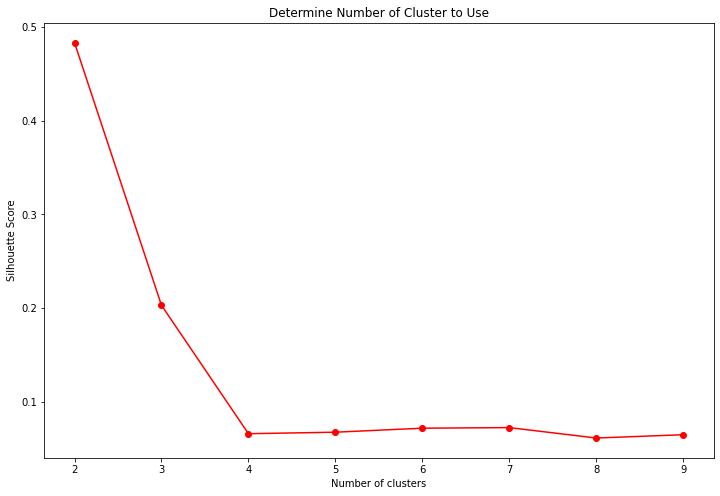

In [46]:
###find best number of clusters
Elbow_grouped_clustering = london_grouped.drop('Neighborhood', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(Elbow_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(Elbow_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(12,8))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.title('Determine Number of Cluster to Use')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

In [47]:
df_lon1 = df_lon.rename(columns={'BoroughName' : 'Neighborhood'})

In [48]:
df_lon1.head()

,Neighborhood,Population,Latitude,Longitude
0,Barking and Dagenham,194352,51.5607,0.1557
1,Barnet,369088,51.6252,-0.1517
2,Bexley,236687,51.4549,0.1505
3,Brent,317264,51.5588,-0.2817
4,Bromley,317899,51.4039,0.0198


In [49]:
# set number of clusters
kclusters = 4

london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 0, 0, 2, 2, 0, 0, 0])

In [50]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Pub,Gas Station,Park,Golf Course,Supermarket,Grocery Store,Turkish Restaurant,Gym / Fitness Center,Diner,Soccer Field
1,Barnet,Park,Bus Stop,Electronics Store,Café,Pub,Fish & Chips Shop,Film Studio,Fish Market,English Restaurant,Farmers Market
2,Bexley,Clothing Store,Pub,Coffee Shop,Supermarket,Hotel,Pharmacy,American Restaurant,Italian Restaurant,Fast Food Restaurant,Furniture / Home Store
3,Brent,Coffee Shop,Hotel,Bar,Clothing Store,Sporting Goods Shop,Sandwich Place,Restaurant,Burger Joint,Grocery Store,Indian Restaurant
4,Bromley,Pub,Coffee Shop,Clothing Store,Supermarket,Pizza Place,Bar,Portuguese Restaurant,Gym / Fitness Center,Burger Joint,Fast Food Restaurant


In [51]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = df_lon1

# merge 
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

london_merged.head() # check the last columns!

,Neighborhood,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,194352,51.5607,0.1557,0,Pub,Gas Station,Park,Golf Course,Supermarket,Grocery Store,Turkish Restaurant,Gym / Fitness Center,Diner,Soccer Field
1,Barnet,369088,51.6252,-0.1517,1,Park,Bus Stop,Electronics Store,Café,Pub,Fish & Chips Shop,Film Studio,Fish Market,English Restaurant,Farmers Market
2,Bexley,236687,51.4549,0.1505,0,Clothing Store,Pub,Coffee Shop,Supermarket,Hotel,Pharmacy,American Restaurant,Italian Restaurant,Fast Food Restaurant,Furniture / Home Store
3,Brent,317264,51.5588,-0.2817,0,Coffee Shop,Hotel,Bar,Clothing Store,Sporting Goods Shop,Sandwich Place,Restaurant,Burger Joint,Grocery Store,Indian Restaurant
4,Bromley,317899,51.4039,0.0198,0,Pub,Coffee Shop,Clothing Store,Supermarket,Pizza Place,Bar,Portuguese Restaurant,Gym / Fitness Center,Burger Joint,Fast Food Restaurant


## Visualise Cluster

In order to visualise the clusters on the map of London Folium will be used. 


In [52]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [53]:
# create map
map_clusters = folium.Map(location=[latitude_lon, longitude_lon], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Step 5 - Examine Clusters
Examine the clusters and determine the similarities and what type of area each cluster group represents

In [54]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Pub,Gas Station,Park,Golf Course,Supermarket,Grocery Store,Turkish Restaurant,Gym / Fitness Center,Diner,Soccer Field
2,Bexley,Clothing Store,Pub,Coffee Shop,Supermarket,Hotel,Pharmacy,American Restaurant,Italian Restaurant,Fast Food Restaurant,Furniture / Home Store
3,Brent,Coffee Shop,Hotel,Bar,Clothing Store,Sporting Goods Shop,Sandwich Place,Restaurant,Burger Joint,Grocery Store,Indian Restaurant
4,Bromley,Pub,Coffee Shop,Clothing Store,Supermarket,Pizza Place,Bar,Portuguese Restaurant,Gym / Fitness Center,Burger Joint,Fast Food Restaurant
7,Ealing,Coffee Shop,Pub,Clothing Store,Gym / Fitness Center,Italian Restaurant,Park,Pizza Place,Burger Joint,Bakery,Thai Restaurant
8,Enfield,Pub,Coffee Shop,Clothing Store,Café,Supermarket,Gift Shop,Pharmacy,Optical Shop,Shopping Mall,Fish & Chips Shop
9,Greenwich,Pub,Grocery Store,Plaza,Coffee Shop,Clothing Store,Fast Food Restaurant,Hotel,Gym / Fitness Center,Supermarket,Bakery
13,Harrow,Indian Restaurant,Supermarket,Gym / Fitness Center,Thai Restaurant,Sandwich Place,Platform,Park,Gym,Grocery Store,Indie Movie Theater
14,Havering,Coffee Shop,Clothing Store,Grocery Store,Shopping Mall,Café,Pub,Fast Food Restaurant,Multiplex,Bookstore,Furniture / Home Store
15,Hillingdon,Coffee Shop,Clothing Store,Fast Food Restaurant,Italian Restaurant,Toy / Game Store,Pharmacy,Pub,Gym,Grocery Store,Burger Joint


In [55]:
cluster1 = london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + 
                                                                                    list(range(4, london_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Coffee Shop             12
Clothing Store          11
Pub                     11
Supermarket              9
Grocery Store            8
Gym / Fitness Center     6
Fast Food Restaurant     6
Italian Restaurant       5
Burger Joint             5
Park                     4
dtype: int64


In [56]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Barnet,Park,Bus Stop,Electronics Store,Café,Pub,Fish & Chips Shop,Film Studio,Fish Market,English Restaurant,Farmers Market


In [57]:
cluster2 = london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + 
                                                                                    list(range(4, london_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Park                  1
Café                  1
Bus Stop              1
Fish & Chips Shop     1
Film Studio           1
Fish Market           1
Farmers Market        1
English Restaurant    1
Pub                   1
Electronics Store     1
dtype: int64


In [58]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Camden,Coffee Shop,Hotel,Café,Pizza Place,Burger Joint,Park,Deli / Bodega,Modern European Restaurant,Italian Restaurant,Breakfast Spot
6,Croydon,Coffee Shop,Pub,Italian Restaurant,Clothing Store,Hotel,Bookstore,Mediterranean Restaurant,Sushi Restaurant,Indian Restaurant,Bar
10,Hackney,Pub,Café,Coffee Shop,Cocktail Bar,Brewery,Bakery,Park,Grocery Store,Organic Grocery,Vegetarian / Vegan Restaurant
11,Hammersmith and Fulham,Pub,Café,Gastropub,Coffee Shop,Indian Restaurant,Gym / Fitness Center,Park,Sandwich Place,Japanese Restaurant,Italian Restaurant
12,Haringey,Fast Food Restaurant,Pub,Café,Turkish Restaurant,Mediterranean Restaurant,Bar,Furniture / Home Store,Gastropub,Coffee Shop,Clothing Store
17,Islington,Pub,Café,Gastropub,Bakery,Park,Mediterranean Restaurant,French Restaurant,Cocktail Bar,Coffee Shop,Ice Cream Shop
18,Kensington and Chelsea,Café,Pub,Garden,Italian Restaurant,Restaurant,Hotel,Juice Bar,Clothing Store,Burger Joint,Cupcake Shop
19,Kingston upon Thames,Coffee Shop,Pub,Café,Italian Restaurant,Clothing Store,Burger Joint,Thai Restaurant,Sandwich Place,Sushi Restaurant,Department Store
20,Lambeth,Coffee Shop,Caribbean Restaurant,Cocktail Bar,Pub,Pizza Place,Beer Bar,Market,Indian Restaurant,Sandwich Place,Food Court
22,Merton,Café,Fast Food Restaurant,Supermarket,Italian Restaurant,Park,Coffee Shop,Burger Joint,Garden Center,Sandwich Place,Bakery


In [59]:
cluster3 = london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + 
                                                                                    list(range(4, london_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Coffee Shop           12
Pub                   11
Café                  10
Italian Restaurant     9
Park                   7
Gastropub              4
Clothing Store         4
Sandwich Place         4
Indian Restaurant      4
Bar                    4
dtype: int64


In [60]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Hounslow,Hotel,Bus Stop,Gym / Fitness Center,Café,Fast Food Restaurant,Middle Eastern Restaurant,Supermarket,Bed & Breakfast,Park,Grocery Store
23,Newham,Hotel,Sandwich Place,Airport Lounge,Airport Service,Light Rail Station,Coffee Shop,Pub,Chinese Restaurant,Duty-free Shop,Restaurant
28,Tower Hamlets,Hotel,Grocery Store,Sandwich Place,Italian Restaurant,Coffee Shop,Fish Market,Bus Station,Pizza Place,Outdoor Sculpture,Market
31,Westminster,Hotel,Coffee Shop,Sandwich Place,Café,Sushi Restaurant,Theater,Restaurant,Bakery,Camera Store,Cheese Shop


In [61]:
cluster4 = london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + 
                                                                                    list(range(4, london_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Hotel                        4
Sandwich Place               3
Coffee Shop                  3
Grocery Store                2
Restaurant                   2
Café                         2
Bus Stop                     1
Camera Store                 1
Middle Eastern Restaurant    1
Outdoor Sculpture            1
dtype: int64


In [62]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [63]:
cluster5 = london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0] + 
                                                                                    list(range(4, london_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Series([], dtype: int64)


In [64]:
london_merged.loc[london_merged['Cluster Labels'] == 5, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [65]:
cluster6 = london_merged.loc[london_merged['Cluster Labels'] == 5, london_merged.columns[[0] + 
                                                                                    list(range(4, london_merged.shape[1]))]]
venues6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

print(venues6.value_counts().head(10))

Series([], dtype: int64)


## Creat plots for the top 5 categories of Venue
Create plots for the top 5 categories of venue within each Cluster in order to use it as a comparison too current location.

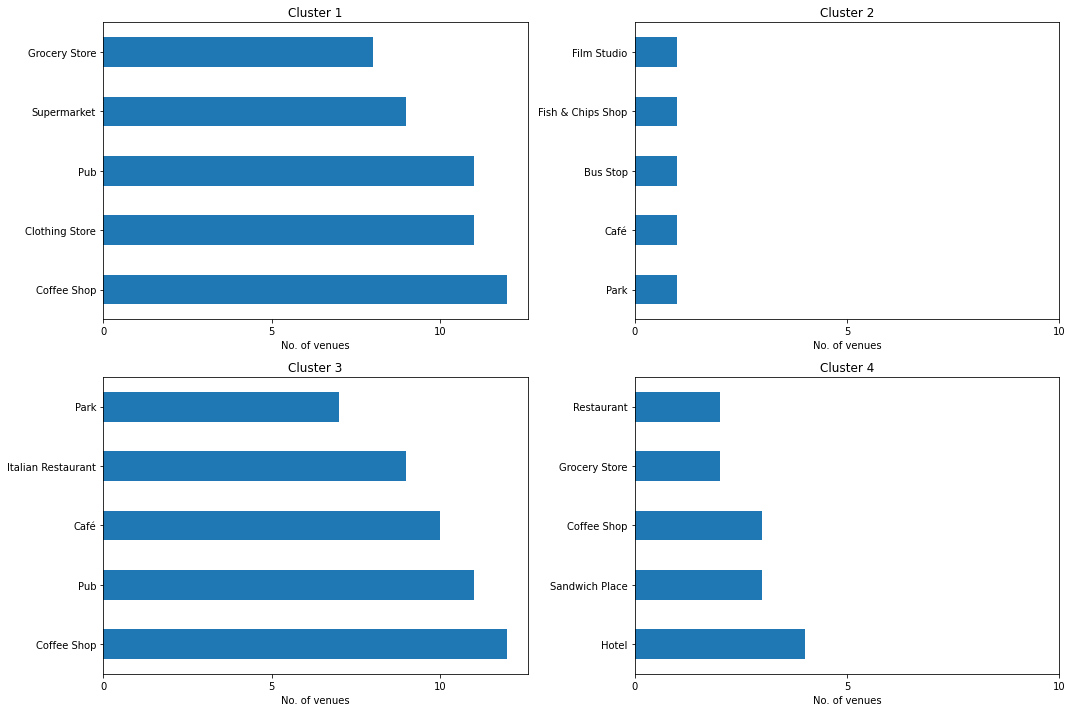

In [66]:
df_list = [venues1 ,venues2, venues3, venues4]
fig, axes = plt.subplots(2, 2)

count = 0
for r in range(2):
    for c in range(2):
        df_list[count].value_counts().head().plot(kind='barh', ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

## Summary - Clusters London 
Its seen that Clusters 2 only contains a single Borough in it Limiting Factors with an Area of this Borough is also that the call to Foursquare API maxed out at the 100 venues in most cases. 

Variables that could be changed include;

The radius of the search from the centre of the Borough (radius =700 m)

The max list of 100 venues being reached by the Foursquare API resulting in capping out of the Boroughs. The way around this would be to split the area into more data points through subdivision of each Borough within London.

Additional metrics could also be included to aid in the determination of similarities and differences between areas.


# PART 2 - Larnaca
## Repeat Process for Current Location
The process is repeated for a single Location point of the current residence. This is used as the basis to then compare the other clusters when selecting the Cluster of best fit.

The location to be compared to is Larnaca, Cyprus.

## Turn the larnaca single point into a cluster equivalent of london and new york to be able to compare.

This will be the same but without a list of place,
Increase the radius to capture close as possible to the 100 venues

In [67]:
# type your answer here
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 5000 # define radius
latitude = 34.923096
longitude = 33.634045 
cy_venues_list=[]


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

url

# make the GET request
cy_results = requests.get(url).json()["response"]['groups'][0]['items']

cy_venues_list.append([(
            'Larnaca', #change name for 'Larnaca' 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in cy_results])

cy_nearby_venues = pd.DataFrame([item for cy_venue_list in cy_venues_list for item in cy_venue_list])
cy_nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
 
cy_nearby_venues
#return(cy_nearby_venues)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Larnaca,51.4973,-74.08174,Holy Cow,34.926526,33.636339,Bistro
1,Larnaca,51.4973,-74.08174,Souvlakia Eftimis,34.923316,33.633907,Souvlaki Shop
2,Larnaca,51.4973,-74.08174,Zorpas,34.918729,33.634796,Bakery
3,Larnaca,51.4973,-74.08174,Marzano,34.918227,33.636442,Italian Restaurant
4,Larnaca,51.4973,-74.08174,Art Café 1900,34.916598,33.636045,Diner
5,Larnaca,51.4973,-74.08174,Rise Hotel,34.918242,33.633641,Hotel
6,Larnaca,51.4973,-74.08174,Radisson Blu Larnaka,34.931527,33.637243,Hotel
7,Larnaca,51.4973,-74.08174,Ocean Basket,34.915233,33.637803,Seafood Restaurant
8,Larnaca,51.4973,-74.08174,PAUL'S Coffee Roasters,34.914360,33.634964,Coffee Roaster
9,Larnaca,51.4973,-74.08174,American Steak Bar,34.916822,33.634545,Burger Joint


In [68]:
#try
venues_count1 = cy_nearby_venues.groupby('Neighborhood').count()
venues_count1

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Larnaca,100,100,100,100,100,100


In [69]:
df_lca = cy_nearby_venues.groupby(['Venue Category']).count()
df_lca.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
American Restaurant,1,1,1,1,1,1
Bakery,2,2,2,2,2,2
Bar,1,1,1,1,1,1
Beach,4,4,4,4,4,4
Beach Bar,2,2,2,2,2,2


In [70]:
df_lca3 = cy_nearby_venues.groupby(['Venue Category']).count().reset_index()
df_lca3.sort_values('Venue', ascending=False)

,Venue Category,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
15,Coffee Shop,10,10,10,10,10,10
27,Hotel,7,7,7,7,7,7
22,Greek Restaurant,6,6,6,6,6,6
43,Supermarket,6,6,6,6,6,6
8,Café,5,5,5,5,5,5
31,Lounge,4,4,4,4,4,4
3,Beach,4,4,4,4,4,4
28,Ice Cream Shop,3,3,3,3,3,3
41,Souvlaki Shop,3,3,3,3,3,3
29,Italian Restaurant,2,2,2,2,2,2


In [74]:
df_lca4 = df_lca3.sort_values('Venue', ascending=False).reset_index()
df_lca4.head()

,index,Venue Category,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
0,15,Coffee Shop,10,10,10,10,10,10
1,27,Hotel,7,7,7,7,7,7
2,22,Greek Restaurant,6,6,6,6,6,6
3,43,Supermarket,6,6,6,6,6,6
4,8,Café,5,5,5,5,5,5


In [75]:
df_lca4.rename(columns={'Venue' : 'Number Venues'})
df_lca4.drop(['index', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude'], axis=1)

,Venue Category,Venue
0,Coffee Shop,10
1,Hotel,7
2,Greek Restaurant,6
3,Supermarket,6
4,Café,5
5,Lounge,4
6,Beach,4
7,Ice Cream Shop,3
8,Souvlaki Shop,3
9,Italian Restaurant,2


Text(0.5, 1.0, 'Number of venues Larnaca')

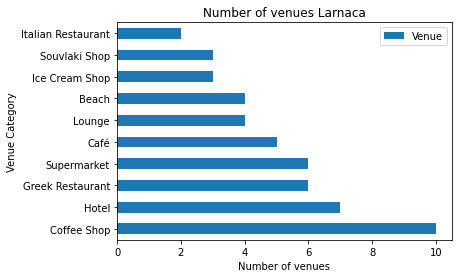

In [76]:
df_lca4[:10].plot(kind='barh', x='Venue Category', y='Venue')
plt.xlabel('Number of venues')
plt.title('Number of venues Larnaca')

Text(0.5, 1.0, 'Number of venues Larnaca')

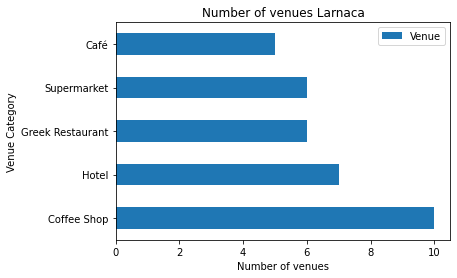

In [77]:
df_lca4[:5].plot(kind='barh', x='Venue Category', y='Venue')
plt.xlabel('Number of venues')
plt.title('Number of venues Larnaca')

## The Number Venue Types Larnaca

The above graph shows that the number of venue types within the current location.

The radius was extended in this search compared to London Boroughs in order to get the larges sample of 100 venues in the town. The Foursquare data density of venues was not as high as in London. 

It can be seen that it is quite a generic type of venue categories with coffee shops, hotel, restaraunts and supermarkets. The only difference being the Greek style restaraunt.

## Further Processing
I carried out the steps similar to London Boroughs with the one hot encoding to allow the dataframes to be merged should I need to add the Cyprus data point into the London dataframe for charting.

In [78]:
# one hot encoding
cy_onehot = pd.get_dummies(cy_nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cy_onehot['Neighborhood'] = cy_nearby_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [cy_onehot.columns[-1]] + list(cy_onehot.columns[:-1])
cy_onehot = cy_onehot[fixed_columns]

cy_onehot.head()

,Neighborhood,American Restaurant,Bakery,Bar,Beach,Beach Bar,Bistro,Breakfast Spot,Burger Joint,Café,Castle,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,Department Store,Dessert Shop,Diner,Dive Spot,Fast Food Restaurant,Furniture / Home Store,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Multiplex,Restaurant,Rock Club,Sandwich Place,Seafood Restaurant,Soccer Stadium,Souvlaki Shop,Steakhouse,Supermarket,Taverna,Theater,Theme Park,Toy / Game Store,Vegetarian / Vegan Restaurant,Wine Bar
0,Larnaca,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Larnaca,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,Larnaca,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Larnaca,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Larnaca,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [79]:
cy_onehot.shape

(100, 51)

In [81]:
cy_grouped = cy_onehot.groupby('Neighborhood').mean().reset_index()
cy_grouped

,Neighborhood,American Restaurant,Bakery,Bar,Beach,Beach Bar,Bistro,Breakfast Spot,Burger Joint,Café,Castle,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,Department Store,Dessert Shop,Diner,Dive Spot,Fast Food Restaurant,Furniture / Home Store,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Multiplex,Restaurant,Rock Club,Sandwich Place,Seafood Restaurant,Soccer Stadium,Souvlaki Shop,Steakhouse,Supermarket,Taverna,Theater,Theme Park,Toy / Game Store,Vegetarian / Vegan Restaurant,Wine Bar
0,Larnaca,0.01,0.02,0.01,0.04,0.02,0.02,0.01,0.01,0.05,0.01,0.02,0.01,0.01,0.01,0.01,0.1,0.01,0.01,0.02,0.01,0.02,0.01,0.06,0.02,0.01,0.01,0.01,0.07,0.03,0.02,0.01,0.04,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.03,0.01,0.06,0.01,0.01,0.02,0.01,0.01,0.01


In [84]:
#created this entry for if i wanted to merge it with london data but didnt utilise
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cy_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
cy_neighborhoods_venues_sorted['Neighborhood'] = cy_grouped['Neighborhood']

for ind in np.arange(cy_grouped.shape[0]):
    cy_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cy_grouped.iloc[ind, :], num_top_venues)

cy_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Larnaca,Coffee Shop,Hotel,Greek Restaurant,Supermarket,Café,Beach,Lounge,Ice Cream Shop,Souvlaki Shop,Italian Restaurant


In [87]:
#try asgain for larnaca
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2500 # define radius
latitude = 34.923096
longitude = 33.634045 

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    latitude, 
    longitude, 
    VERSION, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=JYF4SUTSIUBZHRWW2QJ2D0YO4VYW1W0FIOI512Y11T34L05I&client_secret=NFQO2ABF0M0PW0D514EVCSERJ3U0GZLVDY02YST44JSSPYY1&ll=34.923096,33.634045&v=20180605&radius=2500&limit=100'

In [88]:
results = requests.get(url).json()
'There are {} around larnaca.'.format(len(results['response']['groups'][0]['items']))

'There are 95 around larnaca.'

In [89]:
items = results['response']['groups'][0]['items']
items[0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4f5dd290e4b0c4b68ae9380e',
  'name': 'Souvlakia Eftimis',
  'location': {'lat': 34.92331599185632,
   'lng': 33.633906883653964,
   'labeledLatLngs': [{'label': 'display',
     'lat': 34.92331599185632,
     'lng': 33.633906883653964}],
   'distance': 27,
   'cc': 'CY',
   'country': 'Κύπρος',
   'formattedAddress': ['Κύπρος']},
  'categories': [{'id': '52e81612bcbc57f1066b79f3',
    'name': 'Souvlaki Shop',
    'pluralName': 'Souvlaki Shops',
    'shortName': 'Souvlaki',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/souvlaki_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}},
 'referralId': 'e-0-4f5dd290e4b0c4b68ae9380e-0'}

In [90]:

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']



In [91]:
dataframe = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

dataframe_filtered.head(10)

C:\Users\thoma\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


,name,categories,lat,lng,labeledLatLngs,distance,cc,country,formattedAddress,address,city,state,postalCode,crossStreet,id
0,Souvlakia Eftimis,Souvlaki Shop,34.923316,33.633907,"[{'label': 'display', 'lat': 34.92331599185632...",27,CY,Κύπρος,[Κύπρος],NaN,NaN,NaN,NaN,NaN,4f5dd290e4b0c4b68ae9380e
1,Holy Cow,Bistro,34.926526,33.636339,"[{'label': 'display', 'lat': 34.92652583719508...",435,CY,Κύπρος,"[Nigritas Street, Λάρνακα, Κύπρος]",Nigritas Street,Λάρνακα,Επαρχία Λάρνακας,NaN,NaN,56740e9f498eee4a32d6247f
2,Zorpas,Bakery,34.918729,33.634796,"[{'label': 'display', 'lat': 34.91872937290603...",490,CY,Κύπρος,"[Makarios avenue, Λάρνακα, Κύπρος]",Makarios avenue,Λάρνακα,Επαρχία Λάρνακας,NaN,NaN,5083f5e3e4b0361f673beb96
3,Marzano,Italian Restaurant,34.918227,33.636442,"[{'label': 'display', 'lat': 34.918227, 'lng':...",584,CY,Κύπρος,[Κύπρος],NaN,NaN,NaN,NaN,NaN,4cfcf9092d80a1439b3154d8
4,Rise Hotel,Hotel,34.918242,33.633641,"[{'label': 'display', 'lat': 34.9182418208462,...",541,CY,Κύπρος,"[Kimonos 1, 6015, Κύπρος]",Kimonos 1,NaN,NaN,6015,NaN,571b485a498eb53aef4bb51c
5,Art Café 1900,Diner,34.916598,33.636045,"[{'label': 'display', 'lat': 34.91659795777647...",746,CY,Κύπρος,"[Stasinou Street 6, Λάρνακα, Κύπρος]",Stasinou Street 6,Λάρνακα,Επαρχία Λάρνακας,NaN,NaN,4cd44d9dfb5954810188d750
6,Γυρεύοντας Ελλάδα,Greek Restaurant,34.917672,33.636412,"[{'label': 'display', 'lat': 34.91767163608162...",641,CY,Κύπρος,"[Γρ. Αυξεντίου 2, Λάρνακα, Κύπρος]",Γρ. Αυξεντίου 2,Λάρνακα,Επαρχία Λάρνακας,NaN,NaN,50b767ede4b037d8eeaebd27
7,American Steak Bar,Burger Joint,34.916822,33.634545,"[{'label': 'display', 'lat': 34.91682177913198...",699,CY,Κύπρος,[Κύπρος],NaN,NaN,NaN,NaN,NaN,4f48b49ce4b0dd9bf48af960
8,Ocean Basket,Seafood Restaurant,34.915233,33.637803,"[{'label': 'display', 'lat': 34.91523306913513...",940,CY,Κύπρος,"[Leoforos 8 (Athinon Ave), Λάρνακα, Κύπρος]",Leoforos 8,Λάρνακα,Επαρχία Λάρνακας,NaN,Athinon Ave,4e42a96452b18686a822117d
9,Radisson Blu Larnaka,Hotel,34.931527,33.637243,"[{'label': 'display', 'lat': 34.93152677000027...",982,CY,Κύπρος,"[Λάρνακα, Κύπρος]",NaN,Λάρνακα,Επαρχία Λάρνακας,NaN,NaN,5a38c96a898bdc697425b092


## Visualise Larnaca Map

Create a map of the venues of interest around Larnaca using Folium,

In [92]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around Ecco


# add Ecco as a red circle mark
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup='Ecco',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(venues_map)


# add popular spots to the map as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

## Summary

This project so far consists of generating popular venue Types in London boroughs and clustering them together for similar types.

The current location of Larnaca, Cyprus is then used as a reference point to try and compare the best areas. 

The conclusions in reality is that there is not enough information in the project in its current guise to make a fully informed decision and more work would need to be carrie dout in order to allow for a fully informed decision. 

I intend to continue on with this notebook after submitting it for review and add on additional metrics or try it with a different city to further my knoweldge and development within Python and come up with a better result.

## Further Scope

**Reduce Area Size** - This process could then be iterated down to a reduced geographical area to further refine the process.With only the Foursquare venue groups of 100 venues per borough not enough could be determined about a large Borough to fully make a decision. Iterating down to each neighborhood within a borough would be a likely improvement. 

**Add additional Metrics**  Additional data sources such as crime figures, real estate prices, transport links and school information could be compared to find the most appropriate location.

**Combination** - Ideally reducing the area investigated and combining it with additional metrics would allow the best selection of the area similar to the current one. 


### Thank you for taking the time to view this notebook.